In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import sys

In [14]:
image = cv2.imread('a.jpg',-1)
image = cv2.resize(image,(1000,750))

ret, thresh_gray = cv2.threshold(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY),
                        153, 255, cv2.THRESH_BINARY)

# Threshold Values = 153,255 Working with most
img, contours, hier = cv2.findContours(thresh_gray, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]

# x,y,w,h = cv2.boundingRect(biggest_contour)
# print(x,y,w,h)
# ROI = paper[y:y+h, x:x+w]
# plt.imshow(ROI)

#cv2.drawContours(image, [biggest_contour], 0, (0, 255,0), 1)
#plt.imshow(image)

rect = cv2.minAreaRect(biggest_contour)
box = cv2.boxPoints(rect)
#box = np.int0(box)




# for c in contours:
#     rect = cv2.minAreaRect(c)
#     box = cv2.boxPoints(rect)
#     print(box)
#     # convert all coordinates floating point values to int
#     box = np.int0(box)
#     # draw a green 'nghien' rectangle
#     cv2.drawContours(image, [box], 0, (0, 255, 0),1)
    

# rgb_planes = cv2.split(image)

# result_planes = []
# result_norm_planes = []
# for plane in rgb_planes:
#     dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
#     bg_img = cv2.medianBlur(dilated_img, 21)
#     diff_img = 255 - cv2.absdiff(plane, bg_img)
#     norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
#     result_planes.append(diff_img)
#     result_norm_planes.append(norm_img)

# result = cv2.merge(result_planes)
# result_norm = cv2.merge(result_norm_planes)

# #plt.imshow(result)
# plt.imshow(result_norm)
# paper = result_norm

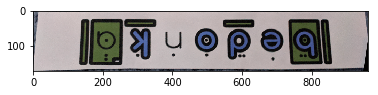

In [15]:
def order_points(pts):
	# initialzie a list of coordinates that will be ordered
	# such that the first entry in the list is the top-left,
	# the second entry is the top-right, the third is the
	# bottom-right, and the fourth is the bottom-left
	rect = np.zeros((4, 2), dtype = "float32")

	# the top-left point will have the smallest sum, whereas
	# the bottom-right point will have the largest sum
	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]

	# now, compute the difference between the points, the
	# top-right point will have the smallest difference,
	# whereas the bottom-left will have the largest difference
	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]

	# return the ordered coordinates
	return rect

def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect

	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))

	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))

	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")

	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

	# return the warped image
	return warped

final_image = four_point_transform(image,box)
plt.imshow(final_image)

In [16]:
template = cv2.imread('k-outline.png', cv2.IMREAD_UNCHANGED)    

#make mask of where the transparent bits are
trans_mask = template[:,:,3] == 0

#replace areas of transparency with white and not transparent
template[trans_mask] = [255, 255, 255, 255]

#new image without alpha channel...
template = cv2.cvtColor(template, cv2.COLOR_BGRA2BGR)
template = cv2.resize(template,(500,95))
cv2.imwrite('outline.jpg', template)
template = cv2.imread('outline.jpg', 0)

sift = cv2.xfeatures2d.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(template, None)
keypoints2, descriptors2 = sift.detectAndCompute(final_image, None)

template_keypoints = cv2.drawKeypoints(template, keypoints1, None)
image_keypoints = cv2.drawKeypoints(final_image, keypoints2, None)

cv2.imwrite('template_keypoints.jpg', template_keypoints)
cv2.imwrite('image_keypoints.jpg', image_keypoints)

True

In [17]:
minimum_matches = 10

parameterIndex = dict(algorithm = 0, trees = 5)
parameterSearch = dict(checks = 50)

matches = cv2.FlannBasedMatcher(parameterIndex, parameterSearch).knnMatch(descriptors1,descriptors2,k=2)

# ratio test to determine good matches
goodMatches = []
for a,b in matches:
    if a.distance < 0.7*b.distance:
        goodMatches.append(a)

if (len(goodMatches) >= 1):
    

    print("good Matches are: ", len(goodMatches))
## Task3: Compute Homography and localize the object.
sourcePoints = np.float32([ keypoints1[a.queryIdx].pt for a in goodMatches ]).reshape(-1,1,2)
destinationPoints = np.float32([ keypoints2[a.trainIdx].pt for a in goodMatches ]).reshape(-1,1,2)

#print(sourcePoints,destinationPoints)
masksNum, mask = cv2.findHomography(sourcePoints, destinationPoints, cv2.RANSAC, 5.0)
maskMatched = mask.ravel().tolist()
height,weight = template.shape
points = np.float32([[0,0],[0,height-1],[weight-1,height-1],[weight-1,0]]).reshape(-1,1,2)
print(points)
destination = cv2.perspectiveTransform(points,masksNum)
#image = cv2.polylines(final_image,[np.int32(destination)],True,255,3, cv2.LINE_AA)
#plt.imshow(image)

good Matches are:  7
[[[  0.   0.]]

 [[  0.  94.]]

 [[499.  94.]]

 [[499.   0.]]]


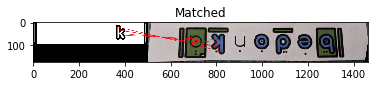

True

In [18]:
draw_params = dict(matchColor = (255,0,0), singlePointColor = None, matchesMask = maskMatched, flags = 2)
matchedImage = cv2.drawMatches(template,keypoints1,final_image,keypoints2,goodMatches,None,**draw_params)
plt.imshow(matchedImage, 'gray')
plt.title('Matched')
plt.show()
cv2.imwrite('Matched_Features.jpg', matchedImage)